# Initial import & data loading

In [1]:
#___________________________________________
# import libraries
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
#___________________________________________
# import data
flights2008 = pd.read_csv('C:/Users/Divyankit/Kaggle/AOTP/Data/Input/flights2008.zip', compression='zip', header=0, sep=',', quotechar='"')
#flights2008 = pd.read_csv('http://stat-computing.org/dataexpo/2009/2008.csv.bz2', compression='bz2', header=0, sep=',', quotechar='"')
#flights2007 = pd.read_csv('http://stat-computing.org/dataexpo/2009/2007.csv.bz2', compression='zip', header=0, sep=',', quotechar='"')

'''
flights1 = flights2008[flights2008['Month']==1]
flights2 = flights2008[flights2008['Month']==2]
flights3 = flights2008[flights2008['Month']==3]
'''

#flights = pd.concat([flights1, flights2, flights3])
flights = flights2008

carriers = pd.read_csv('C:/Users/Divyankit/Kaggle/AOTP/Data/Input/carriers.csv')
airports = pd.read_csv('C:/Users/Divyankit/Kaggle/AOTP/Data/Input/airports.csv')
planes = pd.read_csv('C:/Users/Divyankit/Kaggle/AOTP/Data/Input/planes.csv')

pd.set_option("display.max_columns", 999)


In [3]:
#___________________________________________
# data dimensions
print('Dataframe dimensions:', flights.shape)
#____________________________________________________________
# gives some infos on columns types and number of null values
tab_info=pd.DataFrame(flights.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(flights.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(flights.isnull().sum()/flights.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

Dataframe dimensions: (7009728, 29)


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
column type,int64,int64,int64,int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,int64,float64,float64,int64,object,int64,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,136246,0,151649,0,0,0,83365,154699,844,154699,154699,136246,0,0,0,151649,137058,0,6872294,0,5484993,5484993,5484993,5484993,5484993
null values (%),0,0,0,0,1.94367,0,2.16341,0,0,0,1.18928,2.20692,0.0120404,2.20692,2.20692,1.94367,0,0,0,2.16341,1.95525,0,98.0394,0,78.2483,78.2483,78.2483,78.2483,78.2483


# Flight frequencies

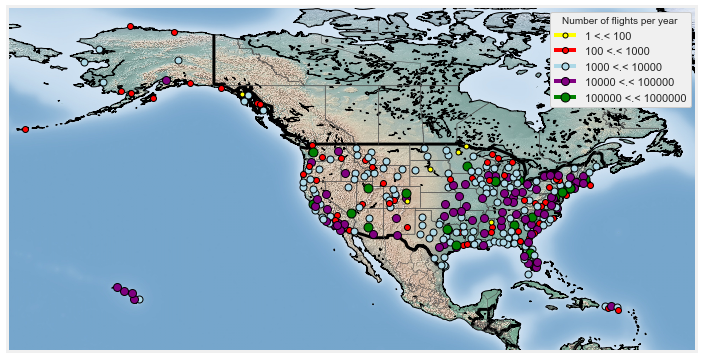

In [4]:
#___________________________________________
# flight frequencies
codes = flights.Origin.unique()
airports = airports[airports['iata'].isin(codes)]

count_flights = flights['Origin'].value_counts()
#___________________________
plt.figure(figsize=(11,11))
#________________________________________
# define properties of markers and labels
colors = ['yellow', 'red', 'lightblue', 'purple', 'green', 'orange']
size_limits = [1, 100, 1000, 10000, 100000, 1000000]
labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1])) 
#____________________________________________________________
map = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')
#_____________________
# put airports on map
for index, (code, y,x) in airports[['iata', 'lat', 'long']].iterrows():
    x, y = map(x, y)
    isize = [i for i, val in enumerate(size_limits) if val < count_flights[code]]
    ind = isize[-1]
    map.plot(x, y, marker='o', markersize = ind+5, markeredgewidth = 1, color = colors[ind],
             markeredgecolor='k', label = labels[ind])
#_____________________________________________
# remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 <.< 100', '100 <.< 1000', '1000 <.< 10000',
             '10000 <.< 100000', '100000 <.< 1000000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 1, prop= {'size':11},
           title='Number of flights per year', frameon = True, framealpha = 1)
plt.show()

In [5]:
#___________________________________________
# date feature
flights['Day'] = flights['DayofMonth']
flights['Date'] = pd.to_datetime(flights[['Year','Month', 'Day']])

In [6]:
#___________________________________________
# few functions
#_________________________________________________________
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
#_____________________________________________________________________
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#_______________________________________________________________________________
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['Date', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

In [7]:
#___________________________________________
# feature format
flights['CRSDepTime'] = create_flight_time(flights, 'CRSDepTime')
flights['DepTime'] = flights['DepTime'].apply(format_heure)
flights['CRSArrTime'] = flights['CRSArrTime'].apply(format_heure)
flights['ArrTime'] = flights['ArrTime'].apply(format_heure)
#__________________________________________________________________________
flights.loc[:5, ['CRSDepTime', 'CRSArrTime', 'DepTime',
             'ArrTime', 'DepDelay', 'ArrDelay']]

,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ArrDelay
0,2008-01-03 19:55:00,22:25:00,20:03:00,22:11:00,8.0,-14.0
1,2008-01-03 07:35:00,10:00:00,07:54:00,10:02:00,19.0,2.0
2,2008-01-03 06:20:00,07:50:00,06:28:00,08:04:00,8.0,14.0
3,2008-01-03 09:30:00,11:00:00,09:26:00,10:54:00,-4.0,-6.0
4,2008-01-03 17:55:00,19:25:00,18:29:00,19:59:00,34.0,34.0
5,2008-01-03 19:15:00,21:10:00,19:40:00,21:21:00,25.0,11.0


In [8]:
#___________________________________________
# feature ommission
variables_to_remove = ['TaxiIn', 'TaxiOut', 'Year', 
                       'Month','DayofMonth', 'Day', 'Date', 'NASDelay',
                       'SecurityDelay', 'CarrierDelay', 'LateAircraftDelay',
                       'WeatherDelay', 'Diverted', 'Cancelled', 'CancellationCode',
                       'FlightNum', 'TailNum', 'AirTime']
flights.drop(variables_to_remove, axis = 1, inplace = True)
flights = flights[['UniqueCarrier', 'Origin', 'Dest', 'DayOfWeek',
        'CRSDepTime', 'DepTime', 'DepDelay',
        'CRSArrTime', 'ArrTime', 'ArrDelay',
        'CRSElapsedTime', 'ActualElapsedTime']]
flights[:5]

,UniqueCarrier,Origin,Dest,DayOfWeek,CRSDepTime,DepTime,DepDelay,CRSArrTime,ArrTime,ArrDelay,CRSElapsedTime,ActualElapsedTime
0,WN,IAD,TPA,4,2008-01-03 19:55:00,20:03:00,8.0,22:25:00,22:11:00,-14.0,150.0,128.0
1,WN,IAD,TPA,4,2008-01-03 07:35:00,07:54:00,19.0,10:00:00,10:02:00,2.0,145.0,128.0
2,WN,IND,BWI,4,2008-01-03 06:20:00,06:28:00,8.0,07:50:00,08:04:00,14.0,90.0,96.0
3,WN,IND,BWI,4,2008-01-03 09:30:00,09:26:00,-4.0,11:00:00,10:54:00,-6.0,90.0,88.0
4,WN,IND,BWI,4,2008-01-03 17:55:00,18:29:00,34.0,19:25:00,19:59:00,34.0,90.0,90.0


In [9]:
#___________________________________________
# missing values
missing_flights =flights.isnull().sum(axis=0).reset_index()
missing_flights.columns = ['variable', 'missing values']
missing_flights['filling factor (%)']=(flights.shape[0]-missing_flights['missing values'])/flights.shape[0]*100
missing_flights.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ArrDelay,154699,97.793081
1,ActualElapsedTime,154699,97.793081
2,ArrTime,151649,97.836592
3,DepTime,136246,98.056330
4,DepDelay,136246,98.056330
5,CRSElapsedTime,844,99.987960
6,UniqueCarrier,0,100.000000
7,Origin,0,100.000000
8,Dest,0,100.000000
9,DayOfWeek,0,100.000000


In [10]:
flights.dropna(inplace = True)
#___________________________________________
#carrier names
abbr_companies = carriers.set_index('Code')['Description'].to_dict()

In [11]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = flights['DepDelay'].groupby(flights['UniqueCarrier']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,count,max,mean,min
UniqueCarrier,,,,
AQ,7752.0,336.0,-1.482456,-61.0
HA,61212.0,963.0,0.439211,-534.0
F9,95384.0,817.0,5.903107,-25.0
AS,148492.0,947.0,6.717439,-79.0
OH,190695.0,960.0,11.510150,-70.0
B6,192114.0,846.0,12.572827,-70.0
YV,245131.0,607.0,11.952744,-92.0
9E,254322.0,1127.0,6.733861,-42.0
FL,258713.0,1206.0,9.229818,-62.0


# Graphs on flights, airports & delays

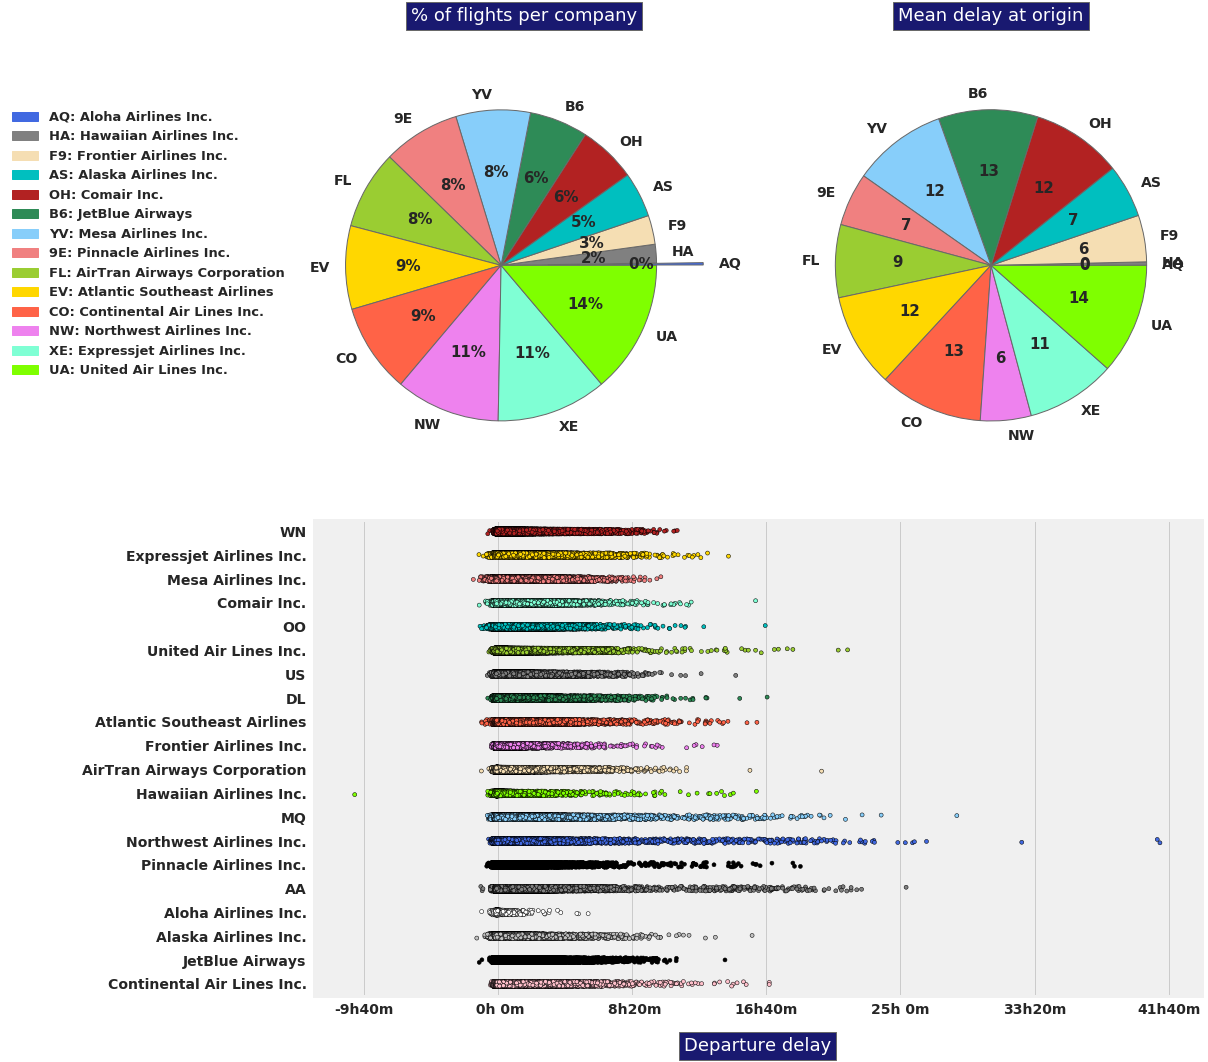

In [12]:
#___________________________________________
# graphs on flights, airports & delays
global_stats1 = global_stats
global_stats = global_stats1.head(14)
codes = global_stats.index.tolist()
carriers1 = carriers[carriers['Code'].isin(codes)]
abbr_companies = carriers1.set_index('Code')['Description'].to_dict()

font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = flights.loc[:, ['UniqueCarrier', 'DepDelay']]
df2['UniqueCarrier'] = df2['UniqueCarrier'].replace(abbr_companies)
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
codes = global_stats1.index.tolist()
carriers1 = carriers[carriers['Code'].isin(codes)]
abbr_companies = carriers1.set_index('Code')['Description'].to_dict()

colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue', 
          'black', 'grey', 'white', 'silver', 'black', 'pink']
#___________________________________________________________________
ax3 = sns.stripplot(y="UniqueCarrier", x="DepDelay", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 

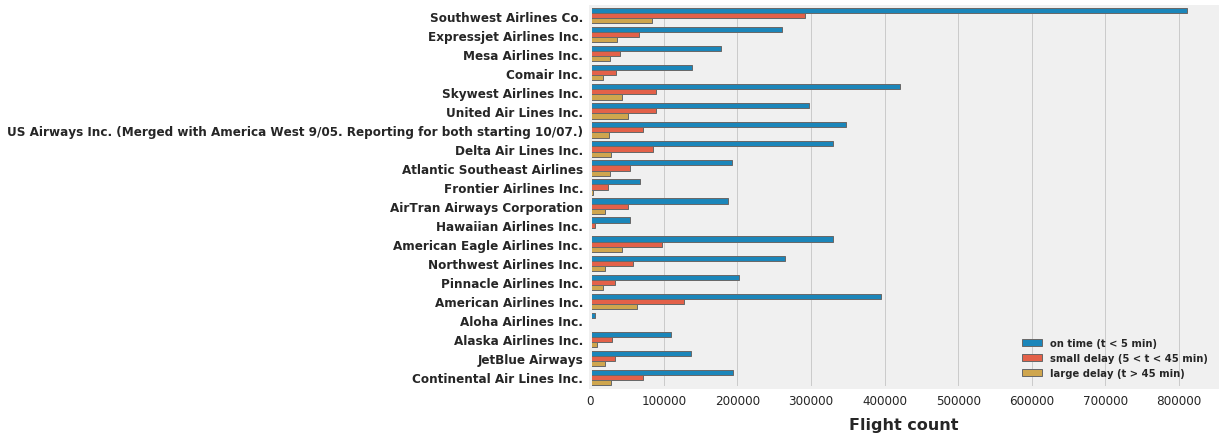

In [13]:
#___________________________________________
# graphs based on delay levels
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
flights['DelayLevel'] = flights['DepDelay'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="UniqueCarrier", hue='DelayLevel', data=flights)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

# Best performing airlines

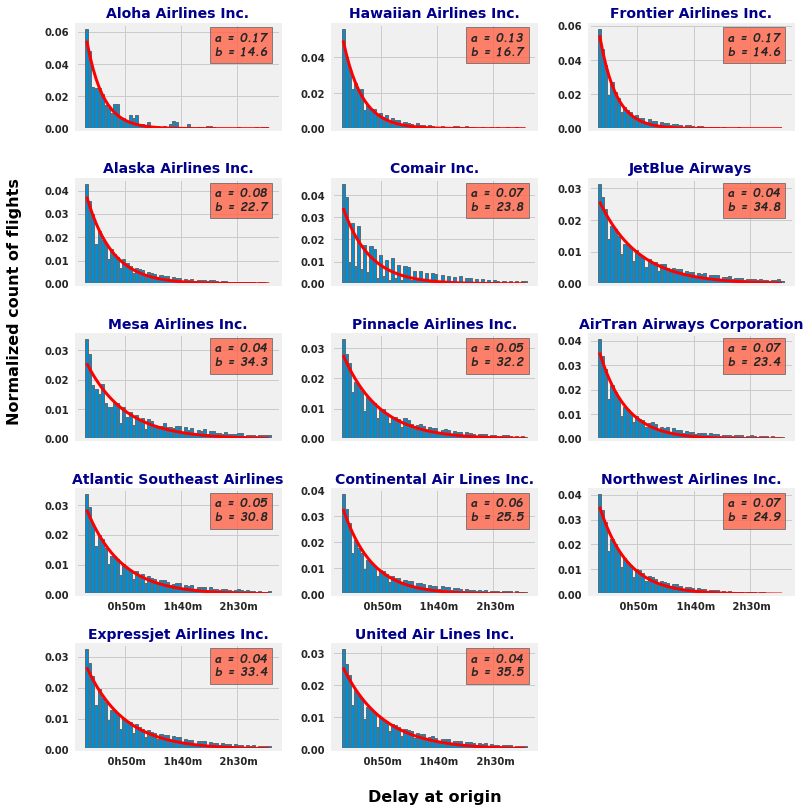

In [14]:
#___________________________________________
# histograms on flights per carrier
#___________________________________________
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i += 1
    ax = fig.add_subplot(5,3,i)    
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x = df2[df2['UniqueCarrier']==carrier_name]['DepDelay'],
                                range = (15,180), normed=True, bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________
    # bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)    
    #_____________________________________
    # define tick labels for each subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    #______________
    # subplot title
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    #____________
    # axes labels 
    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    #___________________________________________
    # Legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})
    
plt.tight_layout()

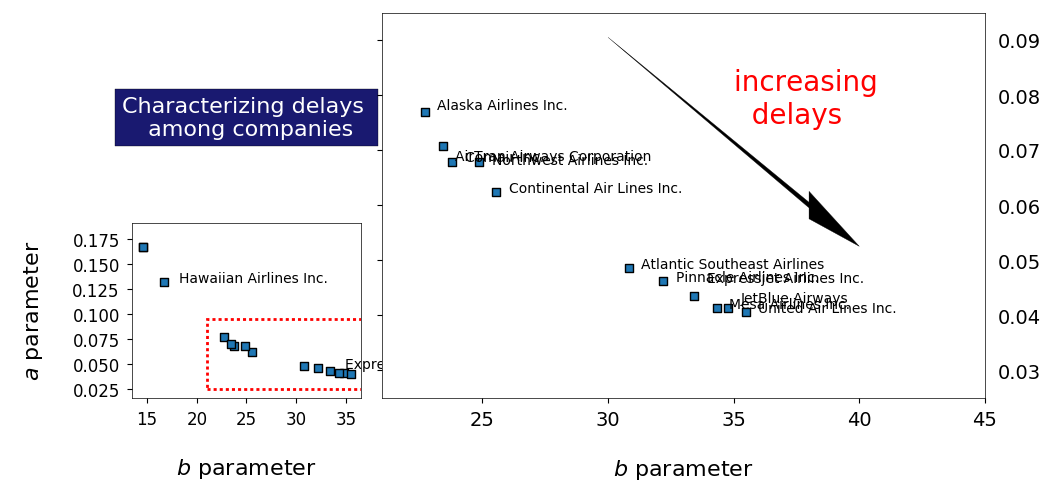

In [15]:
codes = global_stats.index.tolist()
carriers1 = carriers[carriers['Code'].isin(codes)]
abbr_companies = carriers1.set_index('Code')['Description'].to_dict()

mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_context('paper')
import matplotlib.patches as patches

fig = plt.figure(1, figsize=(11,5))
y_shift = [0 for _ in range(14)]
y_shift[3] = 0.5/1000
y_shift[12] = 2.5/1000
y_shift[11] = -0.5/1000
y_shift[8] = -2.5/1000
y_shift[5] = 1/1000
x_val = [s[1] for s in points]
y_val = [s[0] for s in points]

gs=GridSpec(2,7)
#_______________________________
# 1/ Plot overview (left panel)
ax1=fig.add_subplot(gs[1,0:2]) 
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
#__________________________________
# Company label: Hawaiian airlines
i= 1
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#__________________________________
# Company label: Hawaiian airlines
i= 12
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#____________
# Main Title
ax1.text(.5,1.5,'Characterizing delays \n among companies', fontsize=16,
        bbox={'facecolor':'midnightblue', 'pad':5}, color='w',
        horizontalalignment='center',
        transform=ax1.transAxes)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax1.spines[k].set_visible(True)
    ax1.spines[k].set_linewidth(0.5)
    ax1.spines[k].set_color('k')
#____________________
# Create a Rectangle 
rect = patches.Rectangle((21,0.025), 19, 0.07, linewidth=2,
                         edgecolor='r', linestyle=':', facecolor='none')
ax1.add_patch(rect)
#_______________________________________________
# 2/ Zoom on the bulk of carriers (right panel)
ax2=fig.add_subplot(gs[0:2,2:])
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax2.set_xlim(21,45)
ax2.set_ylim(0.025,0.095)
#________________
# Company labels
for i in range(len(abbr_companies)):
    ax2.annotate(label_company[i], xy=(x_val[i]+0.5, y_val[i]+y_shift[i]),
                 xycoords='data', fontsize = 10)
#____________________________
# Increasing delay direction
ax2.arrow(30, 0.09, 8, -0.03, head_width=0.005,
          shape = 'full', head_length=2, fc='k', ec='k')
ax2.annotate('increasing \n  delays', fontsize= 20, color = 'r',
          xy=(35, 0.075), xycoords='data')
#________________________________
# position and size of the ticks
plt.tick_params(labelleft=False, labelright=True)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax2.spines[k].set_visible(True)
    ax2.spines[k].set_linewidth(0.5)
    ax2.spines[k].set_color('k')    
#________________________________
# Connection between the 2 plots
xy2 = (40, 0.09) ; xy1 = (21, 0.095)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
xy2 = (40, 0.025) ; xy1 = (21, 0.025)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
#--------------------------------
plt.show()

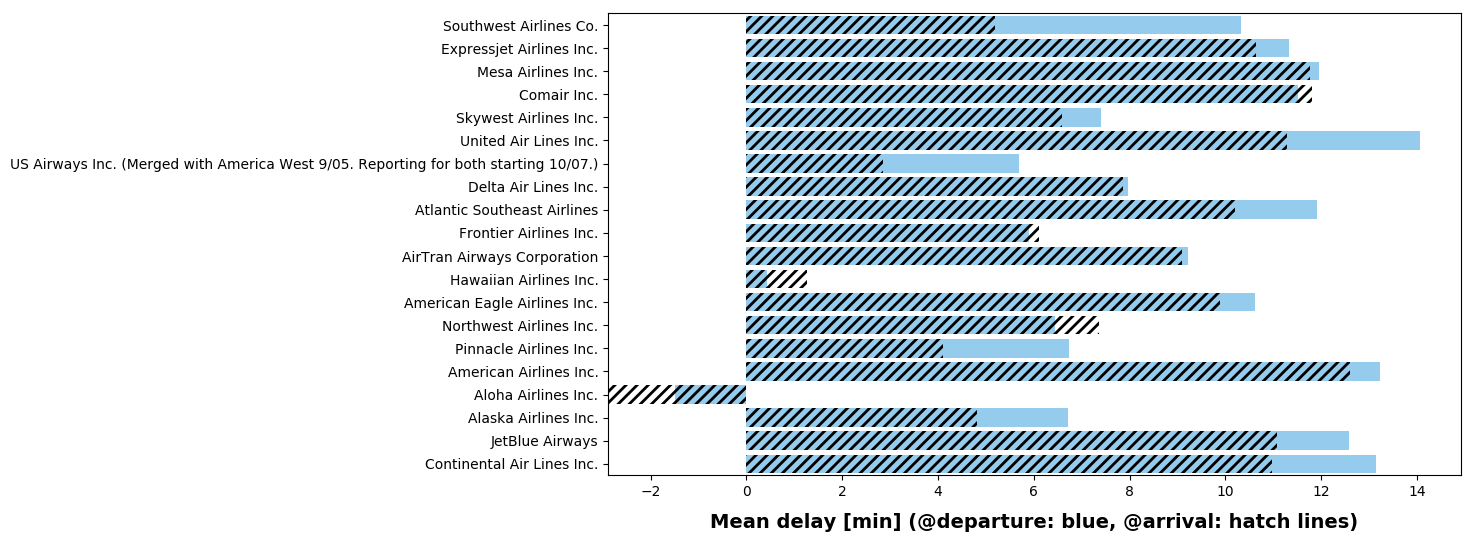

In [16]:
# I redefine the colors for correspondance with the pie charts
codes = global_stats1.index.tolist()
carriers1 = carriers[carriers['Code'].isin(codes)]
abbr_companies = carriers1.set_index('Code')['Description'].to_dict()

#___________________________________________
# mean delay per carrier
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DepDelay", y="UniqueCarrier", data=flights, color="lightskyblue", ci=None)
ax = sns.barplot(x="ArrDelay", y="UniqueCarrier", data=flights, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);

In [17]:
print("Nb of airports: {}".format(len(flights['Origin'].unique())))

Nb of airports: 303


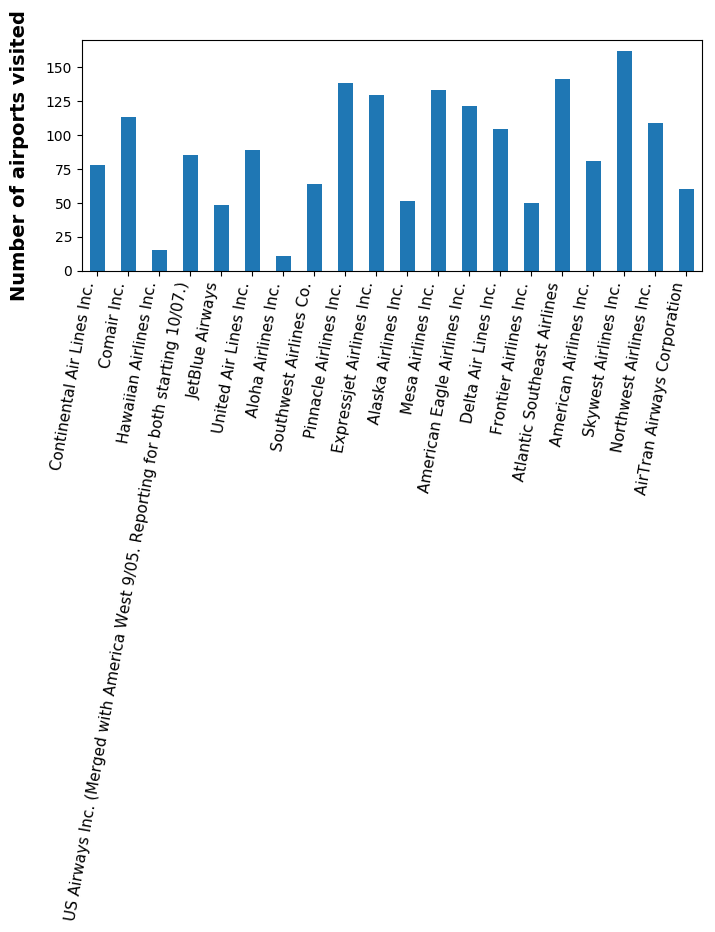

In [18]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = flights[flights['UniqueCarrier'] == carrier]['Origin'].unique()
    origin_nb[carrier] = len(liste_origin_airport)
    
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

In [19]:
temp = pd.read_csv('C:/Users/Divyankit/Kaggle/AOTP/Data/Input/airports.csv')
identify_airport = temp.set_index('iata')['city'].to_dict()
latitude_airport = temp.set_index('iata')['lat'].to_dict()
longitude_airport = temp.set_index('iata')['long'].to_dict()

In [20]:
def make_map(df, carrier, long_min, long_max, lat_min, lat_max):
    fig=plt.figure(figsize=(7,3))
    ax=fig.add_axes([0.,0.,1.,1.])
    m = Basemap(resolution='i',llcrnrlon=long_min, urcrnrlon=long_max,
                  llcrnrlat=lat_min, urcrnrlat=lat_max, lat_0=0, lon_0=0,)
    df2 = df[df['UniqueCarrier'] == carrier]
    count_trajectories = df2.groupby(['Origin', 'Dest']).size()
    count_trajectories.sort_values(inplace = True)
    
    for (origin, dest), s in count_trajectories.iteritems():
        nylat,   nylon = latitude_airport[origin], longitude_airport[origin]
        m.plot(nylon, nylat, marker='o', markersize = 10, markeredgewidth = 1,
                   color = 'seagreen', markeredgecolor='k')

    for (origin, dest), s in count_trajectories.iteritems():
        nylat,   nylon = latitude_airport[origin], longitude_airport[origin]
        lonlat, lonlon = latitude_airport[dest], longitude_airport[dest]
        if pd.isnull(nylat) or pd.isnull(nylon) or \
                pd.isnull(lonlat) or pd.isnull(lonlon): continue
        if s/11 < 100:
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=0.5, color='b',
                             label = '< 100')
        elif s/11 < 200:
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=2, color='r',
                             label = '100 <.< 200')
        else:
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=2, color='gold',
                              label = '> 200')    
    #_____________________________________________
    # remove duplicate labels and set their order
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    key_order = ('< 100', '100 <.< 200', '> 200')                
    new_label = OrderedDict()
    for key in key_order:
        if key not in by_label.keys(): continue
        new_label[key] = by_label[key]
    plt.legend(new_label.values(), new_label.keys(), loc = 'best', prop= {'size':8},
               title='flights per month', facecolor = 'palegreen', 
               shadow = True, frameon = True, framealpha = 1)    
    m.drawcoastlines()
    m.fillcontinents()
    ax.set_title('{} flights'.format(abbr_companies[carrier]))

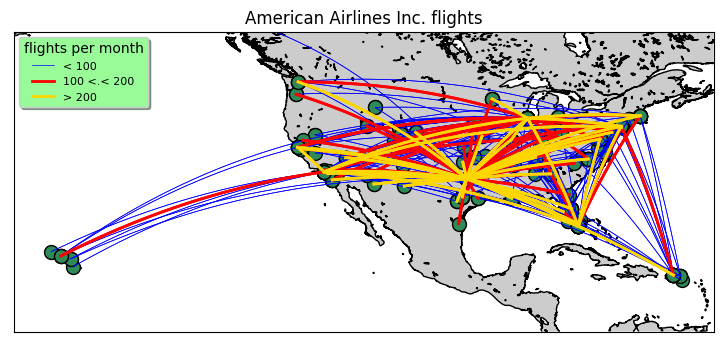

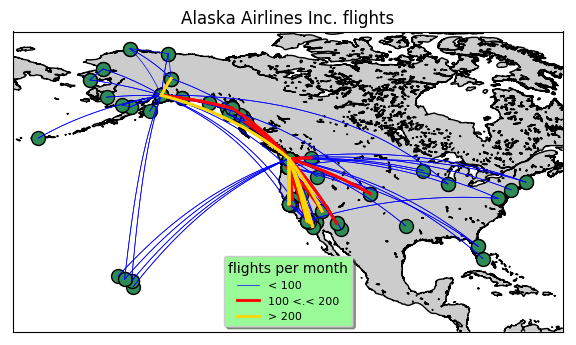

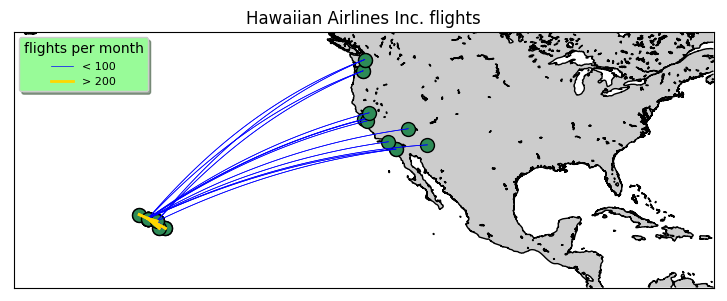

In [21]:
coord = dict()
coord['AA'] = [-165, -60, 10, 55]
coord['AS'] = [-182, -63, 10, 75]
coord['HA'] = [-180, -65, 10, 52]
for carrier in ['AA', 'AS', 'HA']: 
    make_map(flights, carrier, *coord[carrier])

# Impact of origin airport on delay 

In [22]:
airport_mean_delays = pd.DataFrame(pd.Series(flights['Origin'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = flights[flights['UniqueCarrier'] == carrier]
    test = df1['DepDelay'].groupby(flights['Origin']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

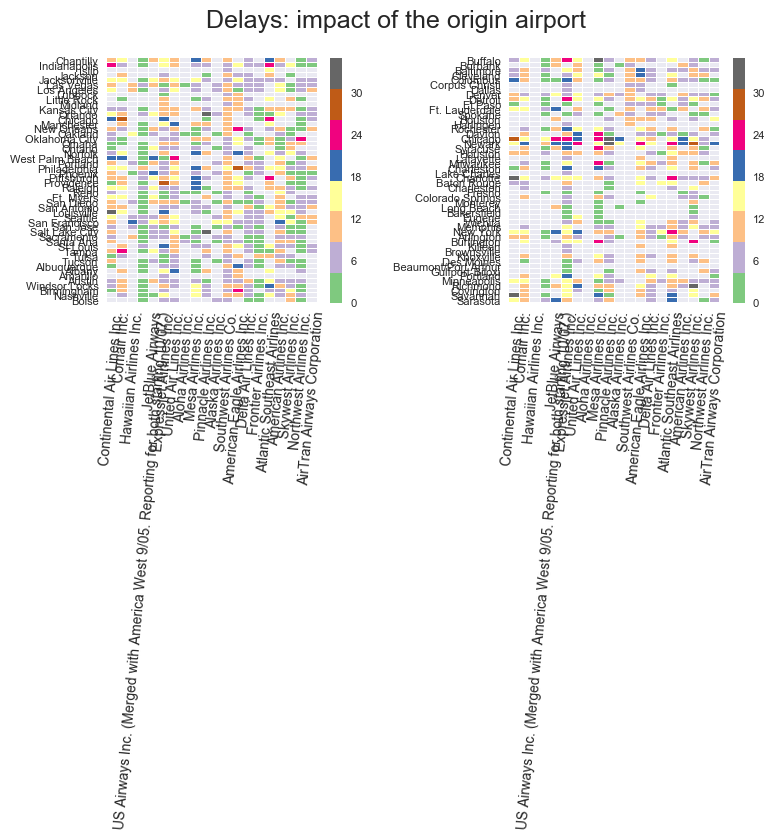

In [23]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

In [24]:
#_________________________________________________________________
# We select the company and create a subset of the main dataframe
carrier = 'AA'
df1 = flights[flights['UniqueCarrier']==carrier][['Origin','Dest','DepDelay']]
#___________________________________________________________
# I collect the routes and list the delays for each of them
trajet = dict()
for ind, col in df1.iterrows():
    if pd.isnull(col['DepDelay']): continue
    route = str(col['Origin'])+'-'+str(col['Dest'])
    if route in trajet.keys():
        trajet[route].append(col['DepDelay'])
    else:
        trajet[route] = [col['DepDelay']]
#____________________________________________________________________        
# I transpose the dictionary in a list to sort the routes by origins        
liste_trajet = []
for key, value in trajet.items():
    liste_trajet.append([key, value])
liste_trajet.sort()


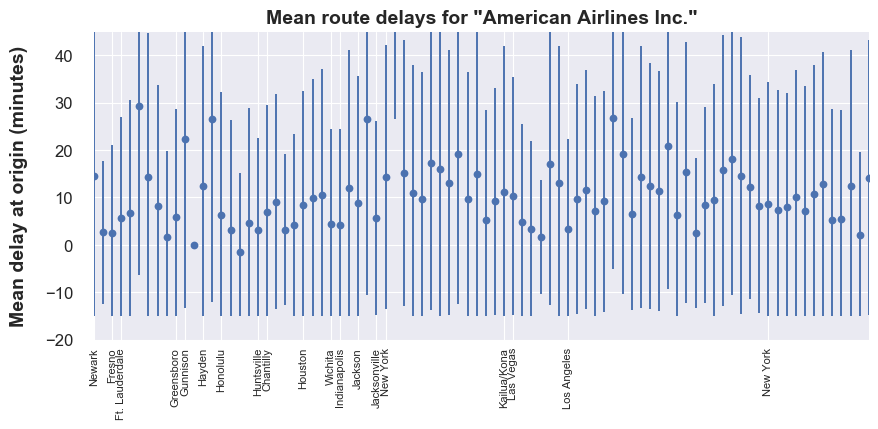

In [25]:
mean_val = [] ; std_val = [] ; x_label = []

i = 0
for route, liste_retards in liste_trajet:
    #_____________________________________________
    # I set the labels as the airport from origin
    index = route.split('-')[0]
    x_label.append(identify_airport[index])
    #______________________________________________________________________________
    # I put a threshold on delays to prevent that high values take too much weight
    trajet2 = [min(90, s) for s in liste_retards]
    #________________________________________
    # I compute mean and standard deviations
    mean_val.append(scipy.mean(trajet2))
    std_val.append(scipy.std(trajet2))
    i += 1
#________________
# Plot the graph
fig, ax = plt.subplots(figsize=(10,4))
std_min = [ min(15 + mean_val[i], s) for i,s in enumerate(std_val)] 
ax.errorbar(list(range(i)), mean_val, yerr = [std_min, std_val], fmt='o') 
ax.set_title('Mean route delays for "{}"'.format(abbr_companies[carrier]),
             fontsize=14, weight = 'bold')
plt.ylabel('Mean delay at origin (minutes)', fontsize=14, weight = 'bold', labelpad=12)
#___________________________________________________
# I define the x,y range and positions of the ticks
imin, imax = 145, 230
plt.xlim(imin, imax) ; plt.ylim(-20, 45)
liste_ticks = [imin]
for j in range(imin+1,imax):
    if x_label[j] == x_label[j-1]: continue
    liste_ticks.append(j)
#_____________________________
# and set the tick parameters  
ax.set_xticks(liste_ticks)
ax.set_xticklabels([x_label[int(x)] for x in ax.get_xticks()], rotation = 90, fontsize = 8)
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0)
ax.tick_params(axis='y', which='major', pad=15)

plt.show()


# Delay date, day of week & time wise

In [26]:
class Figure_style():
    #_________________________________________________________________
    def __init__(self, size_x = 11, size_y = 5, nrows = 1, ncols = 1):
        sns.set_style("white")
        sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x,size_y,))
        #________________________________
        # convert self.axs to 2D array
        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))
    #_____________________________
    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy
    #_______________
    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size = 5)
    #________________________________________
    def draw_legend(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc = location, shadow=True,
                                        facecolor = 'g', frameon = True)
        legend.get_frame().set_facecolor('whitesmoke')
    #_________________________________________________________________________________
    def cust_plot(self, x, y, color='b', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                linewidth = linewidth, marker = marker, label = label,
                                markerfacecolor = markerfacecolor, markersize = markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                        linewidth = linewidth, label=label)
        self.fig.autofmt_xdate()
    #________________________________________________________________________
    def cust_plot_date(self, x, y, color='lightblue', linestyle='-',
                       linewidth=1, markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].plot_date(x, y, color='lightblue', markeredgecolor='grey',
                                  markeredgewidth = markeredgewidth, label=label)
    #________________________________________________________________________
    def cust_scatter(self, x, y, color = 'lightblue', markeredge = False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                  linewidths = markeredgewidth, label=label)    
    #___________________________________________
    def set_xlabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize = fontsize)
    #___________________________________________
    def set_ylabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize = fontsize)
    #____________________________________
    def set_xlim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_xlim([lim_inf, lim_sup])
    #____________________________________
    def set_ylim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_ylim([lim_inf, lim_sup])  

In [27]:
carrier = 'WN'
id_airport = 4
liste_origin_airport = flights[flights['UniqueCarrier'] == carrier]['Origin'].unique()
df2 = flights[(flights['UniqueCarrier'] == carrier) & (flights['ArrDelay'] > 0)
         & (flights['Origin'] == liste_origin_airport[id_airport])]
df2.sort_values('CRSDepTime', inplace = True)

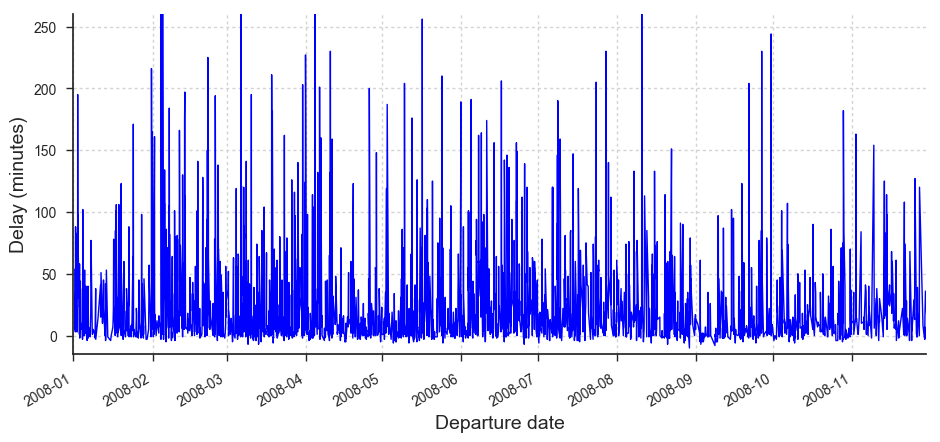

In [28]:
fig1 = Figure_style(11, 5, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_plot(df2['CRSDepTime'], df2['DepDelay'], linestyle='-')
fig1.style() 
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure date', fontsize = 14)
date_1 = datetime.datetime(2008,1,1)
date_2 = datetime.datetime(2008,11,30)
fig1.set_xlim(date_1, date_2)
fig1.set_ylim(-15, 260)

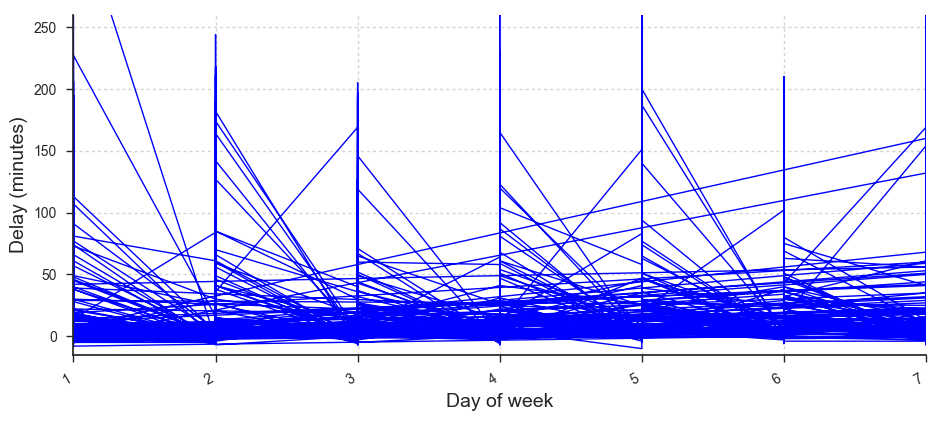

In [29]:
fig1 = Figure_style(11, 5, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_plot(df2['DayOfWeek'], df2['DepDelay'], linestyle='-')
fig1.style() 
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Day of week', fontsize = 14)
dow1 = 1
dow2 = 7
fig1.set_xlim(dow1, dow2)
fig1.set_ylim(-15, 260)

In [30]:
#_______________________________
def func2(x, a, b, c):
    return a * x**2 +  b*x + c
#_______________________________
df2['heure_depart'] =  df2['CRSDepTime'].apply(lambda x:x.time())
test2 = df2['DepDelay'].groupby(df2['heure_depart']).apply(get_stats).unstack()
fct = lambda x:x.hour*3600+x.minute*60+x.second
x_val = np.array([fct(s) for s in test2.index]) 
y_val = test2['mean']
popt, pcov = curve_fit(func2, x_val, y_val, p0 = [1, 2, 3])
test2['fit'] = pd.Series(func2(x_val, *popt), index = test2.index)

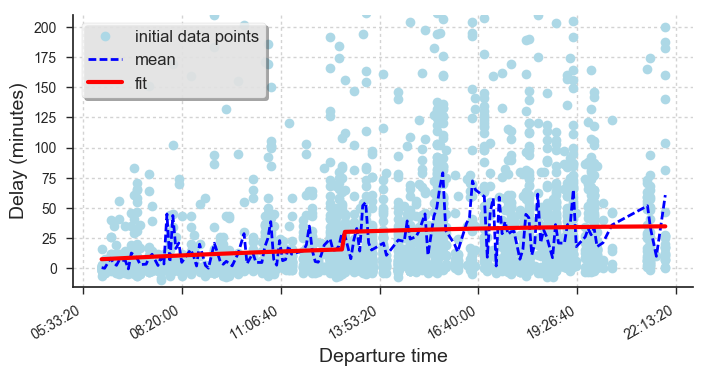

In [31]:
fig1 = Figure_style(8, 4, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_plot_date(df2['heure_depart'], df2['DepDelay'],
                    markeredge=False, label='initial data points')
fig1.cust_plot(test2.index, test2['mean'], linestyle='--', linewidth=2, label='mean')
fig1.cust_plot(test2.index, test2['fit'], color='r', linestyle='-', linewidth=3, label='fit')
fig1.style() ; fig1.draw_legend('upper left')
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure time', fontsize = 14)
fig1.set_ylim(-15, 210)

# Prediction of delay

In [32]:
df_train = flights[flights['CRSDepTime'].apply(lambda x:x.date()) < datetime.date(2008, 11, 30)]
df_test  = flights[flights['CRSDepTime'].apply(lambda x:x.date()) > datetime.date(2008, 1, 1)]
df = df_train

In [33]:
def create_df(df, carrier):
    df2 = df[df['UniqueCarrier'] == carrier][['CRSDepTime','CRSArrTime',
                                    'Origin','Dest','DepDelay']]
    df2.dropna(how = 'any', inplace = True)
    df2['weekday'] = df2['CRSDepTime'].apply(lambda x:x.weekday())
    #____________________
    # delete delays > 1h
    df2['DepDelay'] = df2['DepDelay'].apply(lambda x:x if x < 60 else np.nan)
    df2.dropna(how = 'any', inplace = True)
    #_________________
    # formating times
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    df2['heure_depart'] = df2['CRSDepTime'].apply(lambda x:x.time())
    df2['heure_depart'] = df2['heure_depart'].apply(fct)
    df2['heure_arrivee'] = df2['CRSArrTime'].apply(fct)
    df3 = df2.groupby(['heure_depart', 'heure_arrivee', 'Origin'],
                      as_index = False).mean()
    return df3

In [34]:
df3 = create_df(df, carrier)    
df3[:5]

,heure_depart,heure_arrivee,Origin,DepDelay,weekday
0,20700,24900,ELP,-1.000000,5.000000
1,21600,22800,SLC,1.145299,2.290598
2,21600,23700,TUS,-1.894737,1.894737
3,21600,24600,SAT,-2.611111,1.833333
4,21600,24900,FLL,-1.051546,2.051546


In [35]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df3['Origin'])
#_________________________________________________________
zipped = zip(integer_encoded, df3['Origin'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
#_________________________________________________
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#_________________________________________________
b = np.array(df3[['heure_depart', 'heure_arrivee']])
X = np.hstack((onehot_encoded, b))
Y = np.array(df3['DepDelay'])
Y = Y.reshape(len(Y), 1)

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [37]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = linear_model.Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)
        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)
        
        if score < score_min:
            score_min = score
            parameters = [alpha, pol_order]

        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha/10, score))

n=1 alpha=0.0 , MSE = 35.765
n=1 alpha=0.2 , MSE = 35.873
n=1 alpha=0.4 , MSE = 36.028
n=1 alpha=0.6 , MSE = 36.207
n=1 alpha=0.8 , MSE = 36.397
n=1 alpha=1.0 , MSE = 36.588
n=1 alpha=1.2 , MSE = 36.776
n=1 alpha=1.4 , MSE = 36.957
n=1 alpha=1.6 , MSE = 37.13
n=1 alpha=1.8 , MSE = 37.294
n=2 alpha=0.0 , MSE = 35.802
n=2 alpha=0.2 , MSE = 35.866
n=2 alpha=0.4 , MSE = 35.945
n=2 alpha=0.6 , MSE = 36.005
n=2 alpha=0.8 , MSE = 36.061
n=2 alpha=1.0 , MSE = 36.118
n=2 alpha=1.2 , MSE = 36.178
n=2 alpha=1.4 , MSE = 36.239
n=2 alpha=1.6 , MSE = 36.303
n=2 alpha=1.8 , MSE = 36.367


In [38]:
ridgereg = linear_model.Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)

36.5599002508


In [39]:
df3 = create_df(df_test, carrier)    
df3[:5]

,heure_depart,heure_arrivee,Origin,DepDelay,weekday
0,20700,24900,ELP,-1.000000,5.000000
1,21600,22800,SLC,1.145299,2.290598
2,21600,23700,TUS,-0.975000,1.950000
3,21600,24600,SAT,-2.131579,1.815789
4,21600,24900,FLL,-1.051546,2.051546


In [40]:
label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = s[0]

df3['Origin'].replace(label_conversion, inplace = True)

for index, label in label_airports:
    temp = df3['Origin'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(df3[['heure_depart', 'heure_arrivee']])
X_test = np.hstack((matrix, b))
Y_test = np.array(df3['DepDelay'])
Y_test = Y_test.reshape(len(Y_test), 1)

In [41]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print('MSE = {}'.format(round(score, 2)))

MSE = 40.85


In [42]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

'Ecart = 6.39 min'

In [43]:
icount = 0
for i, val in enumerate(Y_test):
    if abs(val-result[i]) > 15: icount += 1
print("ecarts > 15 minutes: {}%".format(round((icount / len(result))*100,3)))

ecarts > 15 minutes: 2.547%


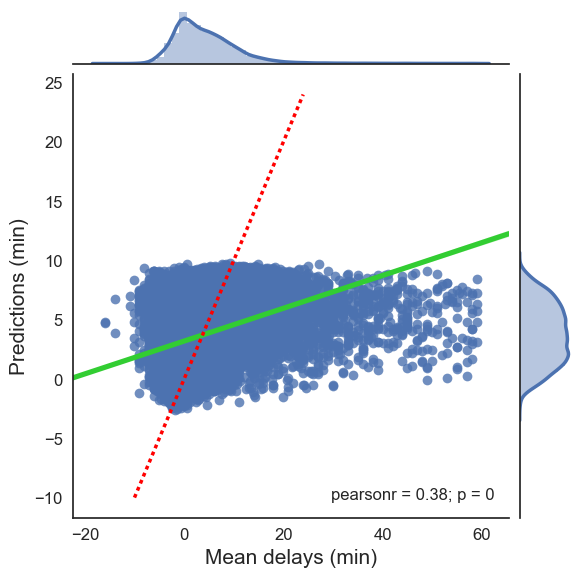

In [44]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in result]) 
tips["original_data"] = pd.Series([float(s) for s in Y_test]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
sns.plt.show()